# Overview

This fine-mapping tutorial was developed using simulated data shipped with [`susieR`](https://github.com/stephenslab/susieR) package.
The simulated data contains simulated phenotype matrix $Y$ in $N \approx 600$ individuals. 
The goal is to identify from the genotype matrix $X_{N\times P}$ ($P=1000$) the genetic variables that directly cause changes in the phenotypic values.

The simulated data-set is [available
here](https://github.com/stephenslab/susieR/blob/master/data/N3finemapping.RData),
as part of the `susieR` package. In this tutorial we will first explore the data with conventional univariate association analysis,
then perform preliminary fine-mapping analysis under simplified 
assumptions to illustrate the idea of statistical fine-mapping, and finally use the R package `susieR` to perform formal Bayesian fine-mapping analysis.
We will also discuss fine-mapping using association summary statistics.

# Explore the association data-set

Please execute the following code cell to load the simulated data,

In [1]:
rm(list=ls())
library(susieR)
data(N3finemapping)
attach(N3finemapping)

In [2]:
ls()

[1] "N3finemapping"

The loaded dataset, `N3finemapping`, contains regression data $X$ and $Y$, 
along with some other relevant attributes in the context of genetic studies. It also
contains the "true" regression coefficients the data is simulated from.

In [3]:
names(N3finemapping)

[1] "X"                 "chrom"             "pos"              
[4] "true_coef"         "residual_variance" "Y"                
[7] "allele_freq"       "V"

The genotype matrix has 574 individuals and 1001 genetic variants,

In [4]:
dim(X)

[1]  574 1001

The phenotype matrix contains values for the 574 individuals for 2 traits,

In [5]:
dim(Y)

[1] 574   2

We focus on the first trait, let

In [6]:
y = Y[,1]
b = true_coef[,1]

There are 3 "causal" variants for this trait,

In [7]:
which(b != 0)

[1] 403 653 773

**Question: Please use R function `plot` to visualize the true effects vector. What are the effect sizes for these 3 "causal" variants?**

Note: in this tutorial we will avoid the phrase "causal", and use "effect variable" to refer to the variants having true non-zero effects on the phenotype.

# Association testing via simple linear regression

`univariate_regression` function in `susieR` can be used to perform association testing 
by fitting univariate simple regression for each variable separately.
The results are $\hat{\beta}$ for effect size estimates, and their standard errors $SE(\hat{\beta})$.

In [8]:
sumstats <- univariate_regression(X, y)

**Question: Please use R function plot to compare the true effects variable `b` with the estimated effect sizes `sumstats$betahat`. Are they consistent, and why?**

z-scores can be derived from these quantities; $-log_{10}$ p-values can then becomputed from z-scores, 

In [9]:
z_scores <- sumstats$betahat / sumstats$sebetahat
log10p <- -log10(pchisq(z_scores^2,1,lower.tail=F))

**Question: How many variables have p-values smaller than $10^{-8}$? Would you report all of them as significant association findings, and if not, which variable(s) will you likely report, based on univariate association analysis?**

`susieR` package provides a plot function to generate Manhattan plot for the association test results. Notice that the true effect variables are labelled in red (true effects provided to `susie_plot` via setting `b=` parameter),

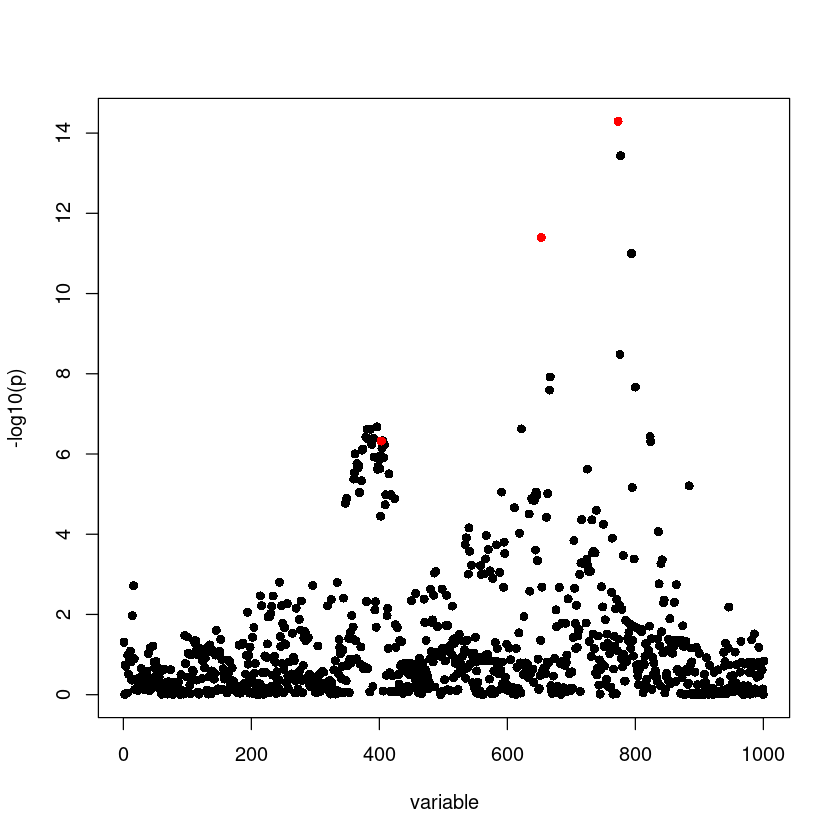

In [10]:
susie_plot(z_scores,y="z",b=b)

As shown on this plot, the "lead" SNP (the one with smallest p-value) is indeed one of the true effect variables. However, the 2nd most significant SNP is not one of the other two effect variables, and there are many other SNPs having p-values smaller than $10^{-8}$, a widely accepted significant level threshold for genetic association studies.

# "One causal variant" assumption for fine-mapping

Under the assumption that there is only one true effect in the region of interest, fine-mapping does not have to use linkage disequilibrium (LD) information between variables. It can be performed by simply calculating the likelihood of the association model for each variable separately, then computing the probability for a variable being the true effect as the ratio of its likelihood over the sum of likelihoods over all variables. We use linear regression `lm` in R to compute the log-likelihood,

In [11]:
lliks = sapply(1:ncol(X), function(i) logLik(lm(y~X[,i])))

Then compute the probability for each variable being the true effect variable: 

In [12]:
lliks = lliks - max(lliks) # To avoid taking exp on large numbers in the next line, thus improving numerical stability 
probs = exp(lliks)/sum(exp(lliks))

We use `susie_plot` function to plot these probabilities computed, and color label the true effect variables:

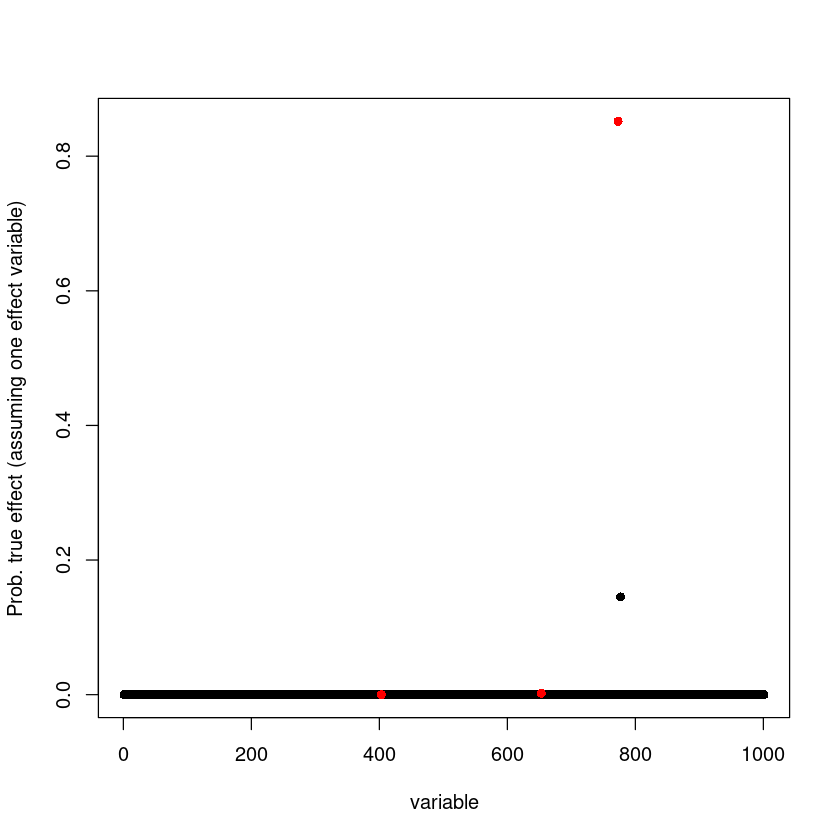

In [13]:
susie_plot(probs, y="PIP", b=b, ylab = "Prob. true effect (assuming one effect variable)")

As expected, under the "one causal variant" assumption, only the lead SNP is identified with over 80% probability of having a non-zero effect. The other two true effect variables in red are not identified.

## 95% credible set for single effect

95% credible set (CS) is defined as a set of variables with 95% probability of containing a true effect. By visually examine the plot above, we can see that the lead SNP has over 80% probability being the true effect, and another SNP near it has almost 20% probability of being the true effect. The 95% credible set should thus contain both of them in order for the coverage to exceed 95%. Indeed, we can formally verify this using an internal function `in_CS` to assess if a variable is in a single effect CS. We report the indices of these variables,

In [14]:
which(susieR:::in_CS(t(probs), coverage = 0.95) != 0)

[1] 773 777

These variables indeed correspond to the two non-zero probability variables on the plot above.

**Question: Show the p-values and probabilities of non-zero effect for these two variables. Compute the correlation between these two variables, and commment on result for the zero effect variable `777`**.

# Fine-mapping with individual level data using Sum of Single Effects model

When multiple true effects are expected, formal statistical fine-mapping via Bayesian Variable Selection
should be performed. We fit a Sum of Single Effects (SuSiE) model implemented in `susieR` package, 
assuming at most 10 causal variables (although SuSiE is robust to the choice of `L`).

In [15]:
fitted <- susie(X, y, L = 10)

## 95% credible sets for each single effect

By default, `susie` function computes 95% CS each containing one effect variable,

In [16]:
print(fitted$sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 362 365 372 373 374 379 381 383 384 386 387 388 389 391 392 396 397 398 399
[20] 400 401 403 404 405 407 408 415


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.8686309     0.9640176       0.9720711

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9539811

$requested_coverage
[1] 0.95



The 3 true signals have been captured by the 3 CS reported here. The
3rd CS contains many variables, including the true causal variable
`403`. The minimum absolute correlation is 0.86.

If we request 90% coverage for credible sets, we still
capture the 3 signals, but the minimum absolute correlation of the 3rd CS is now 0.91 
and size of the CS is also a bit smaller.

In [17]:
sets <- susie_get_cs(fitted, X = X, coverage = 0.9)
print(sets)

$cs
$cs$L2
[1] 653

$cs$L1
[1] 773 777

$cs$L3
 [1] 373 374 379 381 383 384 386 387 388 389 391 392 396 398 399 400 401 403 404
[20] 405 407 408


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2    1.0000000     1.0000000       1.0000000
L1    0.9815726     0.9815726       0.9815726
L3    0.9119572     0.9726283       0.9765888

$cs_index
[1] 2 1 3

$coverage
[1] 0.9998236 0.9988858 0.9119917

$requested_coverage
[1] 0.9



**Question: why is the size for the 3rd CS smaller and minimum absolute correlation higher, when requesting 90% coverage compared to previous result of requesting 95%?**

## Posterior inclusion probabilities

Here we summarize the fine-mapping results by posterior inclusion
probability (PIP):

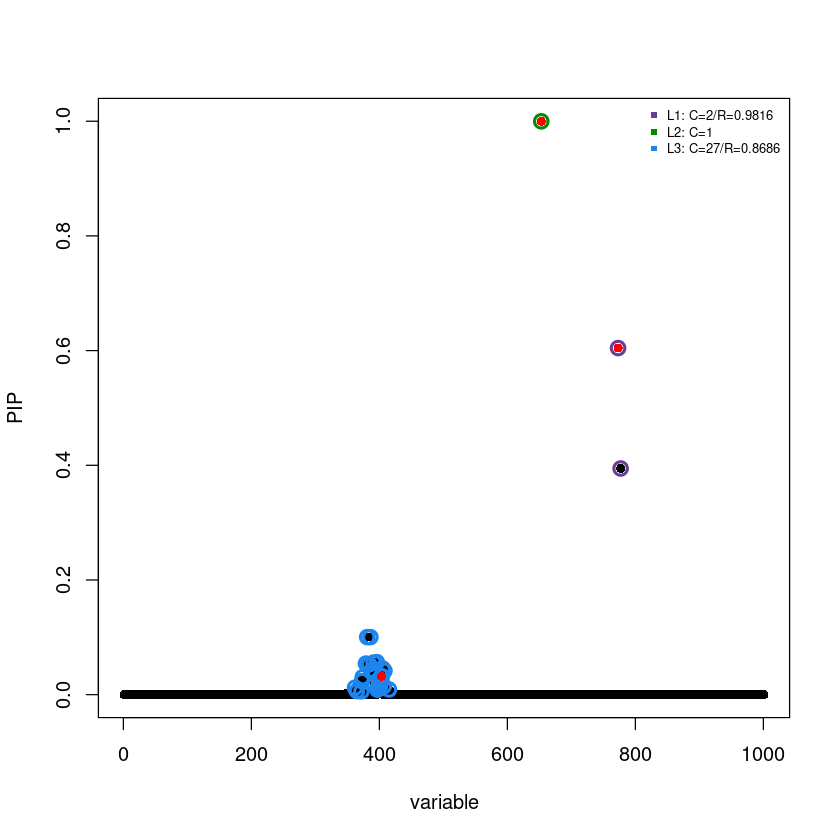

In [18]:
susie_plot(fitted, y="PIP", b=b, add_legend=T)

The true effect variables are colored red, and the three 95% CS identified are
circled in different colors. 

**Question: Report the PIP for variable 403. Why is the PIP relatively low for this true effect variable?** You can use the code below to compare $-log_{10}$ p-value and PIP for the CS containing variable 403:

In [19]:
i  <- fitted$sets$cs$L3
z3 <- cbind(i,log10p[i],fitted$pip[i])
colnames(z3) <- c('position', '-log10 pvalue', 'PIP')
z3[order(z3[,2], decreasing = TRUE),]

position,-log10 pvalue,PIP
396,6.676732,0.056704331
381,6.618518,0.100360243
386,6.618518,0.100360243
379,6.417587,0.054179507
391,6.396640,0.055952118
383,6.370810,0.052896918
384,6.370810,0.052896918
389,6.360493,0.042161265
405,6.331181,0.045761975
403,6.322861,0.031992848


**Question: Please rerun the `susie` analysis setting `L=1` to detect a maximum of only one effect across the region. How does the result compare to the previous section of "one causal effect" fine-mapping using likelihoods from univariate analysis?**

## Choice of prior effect size

In SuSiE, the prior effect size is parameterized by the percentage of variance explained by a variable, $h_j^2$. 
By default, SuSiE estimates $h_j^2$ and uses it as the prior (an empirical Bayes approach). 
Here we demonstrate fixing the prior effect size to 0.2, i.e., we believe a non-zero effect variable can explain 20% variation in quantitative trait values:

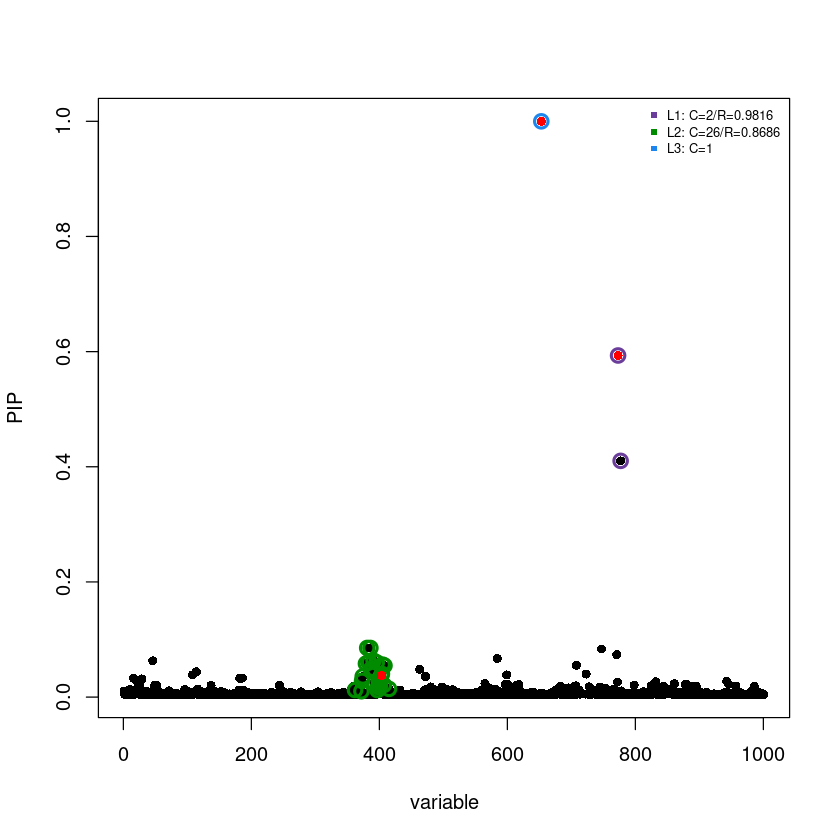

In [20]:
fitted2 = susie(X, y, L = 10, estimate_prior_variance = FALSE, scaled_prior_variance = 0.2)
susie_plot(fitted2, y='PIP', b=b, add_legend=T)

The result is very similar to when prior effects are estimated. 

**Question: Please change `scaled_prior_variance` to different numbers between 0 and 1, and examine the results. What happens if you set it to 0.001, and why?**

# Fine-mapping with summary statistics via `susie_rss`

Summary statistics of genetic association studies typically contain effect size ($\hat{\beta}$ coefficient from regression), p-value and minor allele frequencies. 
These information can be used to perform fine-mapping with given an additional input of correlation matrix between variables.
The correlation matrix in genetics is typically referred to as LD matrix (LD for linkage disequilibrium). 
One may use external reference panels to estimate it when this matrix cannot be obtained from samples directly. There is a potential problem using LD from reference panel, and we demonstrated it in the next section.
Caution that LD matrix here has to be correlation matrix $r$, not $r^2$ or $abs(r)$.

We have previously computed z-scores for this data-set. The correlation matrix can be computed directly from $X$ matrix, 

In [21]:
R <- cor(X)

SuSiE regression with summary statistics is implemented as `susie_rss` function, 

In [22]:
fitted_rss <- susie_rss(z_scores, R, L = 10)

We compare the PIP obtained with previous analysis using individual level data,

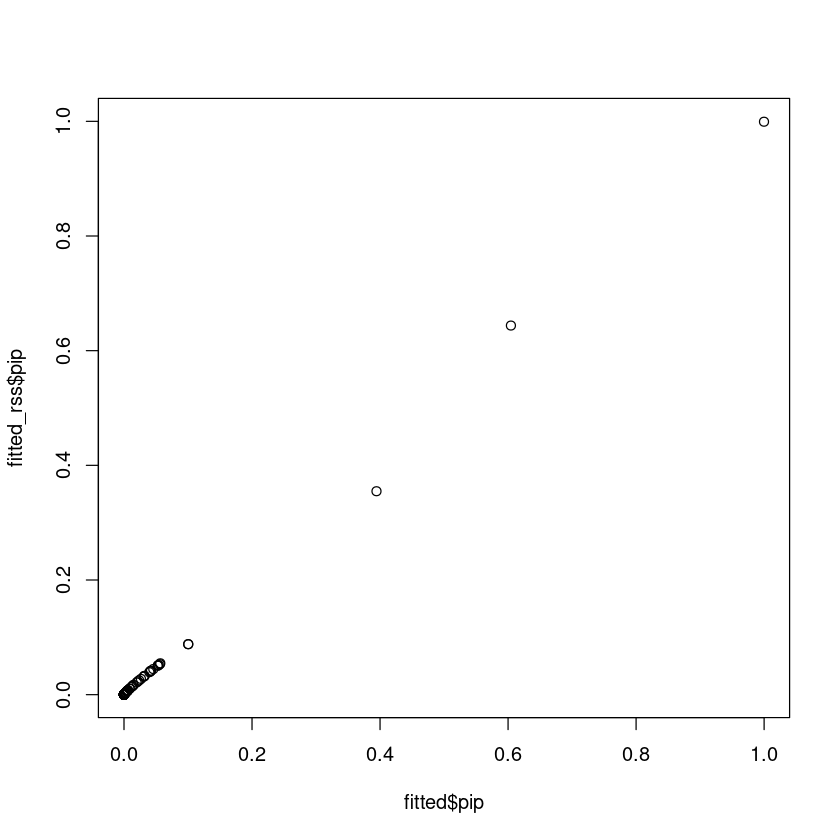

In [23]:
plot(fitted$pip, fitted_rss$pip, ylim=c(0,1))

The results very much agree. This is expected when the summary statistics are indeed derived from the individual level data.

## Use LD from external reference data

When original genotype information is not available, 
one may use reference panel to estimate LD matrix. However, caution should be taken as false discoveries may occur if the LD pattern from the reference panel does not agree well with the original sample. 

To illustrate, we randomly generate a LD reference panel `R_ref`,

In [40]:
set.seed(1234)
tmp = matrix(rnorm(500*1001), 500, 1001)
eigenR = eigen(R)
eigenR$values[eigenR$values < 1e-10] = 0
X_ref = tmp %*% (eigenR$values * t(eigenR$vectors))
R_ref = cor(X_ref)

Using `susie_rss` function with LD from reference panel,

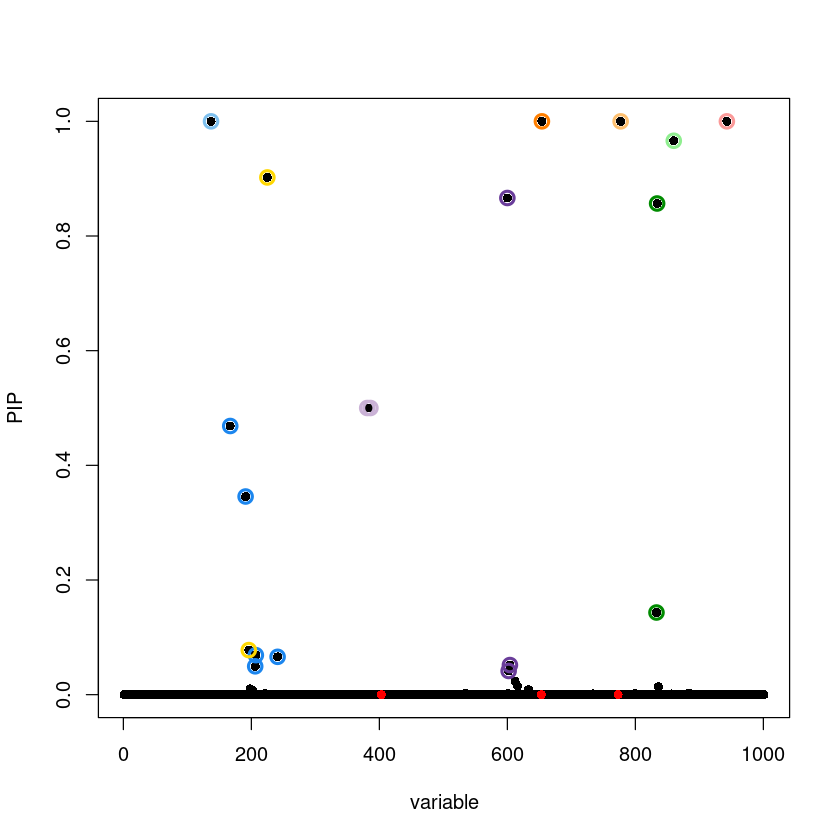

In [35]:
fitted_rss_ref <- susie_rss(z_scores, R_ref, L = 10)
susie_plot(fitted_rss_ref, y="PIP", b=b)

**Question: Please compare and comment on the CS reported using reference LD panel versus using the correct LD computed from genotype data. Are there any false discoveries?**

# Exercise: fine-mapping analysis on a different data-set

Please load and analyze another data-set provided in `susieR` package:

In [27]:
data(N2finemapping)

Please use the same R code for `N3finemapping` data to analyze this new data-set, similarly focusing on the first column of the phenotype matrix as the phenotype of interest. 
This data-set contains two true effect variables. However, as you are soon to find out in univariate linear regression analysis, **the lead SNP via univariate analysis is neither of the two effect variables**.

**Question: Perform fine-mapping under "one causal variant" assumption. Does it capture any true effect? Does fine-mapping with SuSiE capture all true effects?**

In [28]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] susieR_0.10.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6       magrittr_2.0.1   tidyselect_0.2.5 munsell_0.5.0   
 [5] uuid_0.1-2       colorspace_2.0-0 lattice_0.20-38  R6_2.5.0        
 [9] rlang_0.4.10     plyr_1.8.6       dplyr_0.8.3      to